We trained multiple models with the preprocessed dataset, including logistic regression, logistic regression with SGD, logistic regression with SGD and Grid Search CV, and Random Forest with Randomized Search CV. Since the first three methods use logistic regression, we tested a Random Forest classifier model in case a non-linear model works better with the dataset. This seemed plausible since the dataset includes multiple categorical attributes.

Accuracy, precision, and recall were the metrics used to evaluate each model. Precision-recall curves, ROC curves, and learning curves were also generated for each logisitc regression model. Precision-recall and ROC curves were generated for the Random Forest model, but learning curves were not since iteratively training a Random Forest model would take an unfeasible amount of time.

In [199]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, RocCurveDisplay, PrecisionRecallDisplay, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import matplotlib.pyplot as plt
%matplotlib inline

In [200]:
def getMetrics(predictions, X_test, y_test):
    
    #get accuracy
    num_correct = np.sum(predictions == y_test.to_numpy().reshape(-1))
    accuracy = num_correct / len(X_test)
    
    #get precision/recall
    cmatrix = confusion_matrix(y_test, predictions)
    true_neg, false_pos, false_neg, true_pos = cmatrix.ravel()
    
    precision = true_pos/(true_pos+false_pos)
    recall = true_pos / (true_pos + false_neg)
    
    return accuracy, precision, recall

In [201]:
def prCurve(model, X_test, y_test):
    
    precision_all = []
    recall_all = []
    
    probabilities = model.predict_proba(X_test)
    #print(sorted(np.ravel(probabilities)))
    threshold_values = np.linspace(0, 1, num=100)
    
    for threshold in threshold_values:
        predictions = np.array([1 if p[1] >= threshold else 0 for p in probabilities])
        
        precision = precision_score(y_test, predictions, zero_division=1)

        recall = recall_score(y_test, predictions)

        precision_all.append(precision)
        recall_all.append(recall)
    
    plt.figure(figsize=(7, 15))
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(311)
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(recall_all, precision_all, 'b-', linewidth=4.0)
    plt.title("Precision Recall Curve")
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.rcParams.update({'font.size': 16})


In [202]:
def rocCurve(model, X_val, y_val):

    threshold_values = np.linspace(0, 1, num=100)
    
    probabilities = model.predict_proba(X_val)

    tpr_scores = []
    fpr_scores = []
    for threshold in threshold_values:
        predictions = np.array([1 if p[1] >= threshold else 0 for p in probabilities])
        
        cmatrix = confusion_matrix(y_val, predictions)
        true_neg, false_pos, false_neg, true_pos = cmatrix.ravel()
        
        #calculate true positive rate and false positive rate
        tpr = true_pos / (true_pos + false_neg)
        fpr = 1 - (true_neg / (true_neg + false_pos))

        tpr_scores.append(tpr)
        fpr_scores.append(fpr)
    
    roc_auc = auc(fpr_scores, tpr_scores)
    
    plt.subplot(312)
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(fpr_scores, tpr_scores, 'g-', linewidth=4.0)
    plt.title(f"ROC Curve (AUC = {roc_auc})")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.rcParams.update({'font.size': 16})
    

In [203]:
def learningCurve(model, X_train, X_val, y_train, y_val):
    
    train_accuracy, val_accuracy = [], []
    
    for m in range(20, len(X_train) + 1, 5):
        model.fit(X_train[:m], np.ravel(y_train[:m]))
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)

        train_accuracy_val = np.sum(y_train_predict == y_train[:m].to_numpy().reshape(-1)) / m
        val_accuracy_val = np.sum(y_val_predict == y_val.to_numpy().reshape(-1)) / len(X_val)
        train_accuracy.append(train_accuracy_val)
        val_accuracy.append(val_accuracy_val)

    plt.subplot(313)
    plt.locator_params(axis = 'x', nbins = 5)
    plt.plot(list(range(20, len(X_train) + 1, 5)), train_accuracy, 'r-', linewidth=4.0, label = "Training Accuracy")
    plt.plot(list(range(20, len(X_train) + 1, 5)), val_accuracy, 'b-', linewidth=4.0, label="Validation Accuracy")
    plt.title("Learning Curve")
    plt.ylabel('Accuracy')
    plt.xlabel('Training Size')
    plt.rcParams.update({'font.size': 16})
    plt.legend(loc="lower right")

In [204]:
def trainLogModel(X_train, X_test, y_train, y_test):
    
    #fit logistic model
    log_model = LogisticRegression(random_state=0)
    log_model.fit(X_train, np.ravel(y_train))
    
    #get test predictions
    predictions = log_model.predict(X_test)
    
    #get accuracy, precision, and recall scores
    accuracy, precision, recall = getMetrics(predictions, X_test, y_test)
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}")
    
    #plot PR curve
    prCurve(log_model, X_test, y_test)
    
    #plot ROC curve
    rocCurve(log_model, X_test, y_test)
    
    #plot learning curve
    learningCurve(log_model, X_train, X_test, y_train, y_test)
    
    #get coefficients
    coef = log_model.coef_
    
    return coef

In [205]:
def trainSGDModel(X_train, X_test, y_train, y_test):
    
    #define hyperparameters for SGD
    max_iter=10000           # number of passes on training data
    tol=1e-4                # stopping criteria for iterations
    penalty='l2'            # 'l1' and 'l2' regularization term
    alpha=0.001             # Constant that multiplies the regularization term. Ranges from [0 Inf)
    loss='log_loss'              # 'log' is logistic regression, 'hinge' for Support Vector Machine
    random_state=1         # seed of the pseudo random number generated which is used while shuffling the data

    #fit SGD model
    sgd_model = SGDClassifier(max_iter=max_iter, 
                      tol=tol,
                      penalty=penalty,
                      alpha=alpha,
                      loss=loss,
                      random_state=random_state)
    sgd_model.fit(X_train, np.ravel(y_train))
    
    #get test predictions
    predictions = sgd_model.predict(X_test)
    
    #get accuracy, precision, and recall scores
    accuracy, precision, recall = getMetrics(predictions, X_test, y_test)
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}")
    
    #plot PR curve
    prCurve(sgd_model, X_test, y_test)
    
    #plot ROC curve
    rocCurve(sgd_model, X_test, y_test)
    
    #plot learning curve
    learningCurve(sgd_model, X_train, X_test, y_train, y_test)
    
    coef = sgd_model.coef_
    
    return coef

In [206]:
def trainSGD_GridModel(X_train, X_test, y_train, y_test):
    
    #define grid search parameters
    params = {
    'max_iter': [1000, 5000, 10000],
    'tol': [5e-4, 1e-4, 5e-5, 1e-5],
    'penalty': ['l1', 'l2'],
    'alpha': [0.0005, 0.001, 0.005, 0.01],
    }

    #SGD model
    sgd_model = SGDClassifier(loss='log_loss', random_state=1)
    
    #cross-validate
    n_splits=5
    n_repeats=10
    sgd_cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    
    #fit grid search model
    grid_search = GridSearchCV(estimator=sgd_model, param_grid=params, cv=sgd_cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, np.ravel(y_train))
    
    best_model = grid_search.best_estimator_
    print(grid_search.best_params_)
    
    #get test predictions
    predictions = best_model.predict(X_test)
    
    #get accuracy, precision, and recall scores
    accuracy, precision, recall = getMetrics(predictions, X_test, y_test)
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}")
    
    #plot PR curve
    prCurve(best_model, X_test, y_test)
    
    #plot ROC curve
    rocCurve(best_model, X_test, y_test)
    
    #plot learning curve
    learningCurve(best_model, X_train, X_test, y_train, y_test)
    
    #get coefficients
    coef = best_model.coef_
    
    return coef

In [207]:
def trainRFModel(X_train, X_test, y_train, y_test):
    
    param_dist = {'n_estimators': randint(50,500),
               'max_depth': randint(1,10),
               'bootstrap': [True, False]}

    #create random forest classifier
    rf = RandomForestClassifier()

    #use random search to find the best hyperparameters
    rand_search = RandomizedSearchCV(rf, 
                                     param_distributions = param_dist, 
                                     n_iter=100, 
                                     cv=5)

    #fit the random search object to the data
    rand_search.fit(X_train, np.ravel(y_train))
    
    #get the best model
    best_rf = rand_search.best_estimator_
    print('Best hyperparameters:',  rand_search.best_params_)
    
    #get accuracy, precision, and recall scores
    predictions = best_rf.predict(X_test)
    accuracy, precision, recall = getMetrics(predictions, X_test, y_test)
    print(f"accuracy: {accuracy}, precision: {precision}, recall: {recall}")
    
    #plot PR Curve
    PrecisionRecallDisplay.from_estimator(best_rf, X_test, y_test)
    
    #plot ROC curve
    RocCurveDisplay.from_estimator(best_rf, X_test, y_test)

In [208]:
bmt_std = pd.read_csv("./BMT_standardized_v3.csv")
print(bmt_std.columns)

Index(['Recipientgender', 'Stemcellsource', 'Donorage', 'Gendermatch',
       'RecipientRh', 'ABOmatch', 'CMVstatus', 'DonorCMV', 'RecipientCMV',
       'Riskgroup', 'Diseasegroup', 'HLAmatch', 'HLAmismatch', 'Antigen',
       'Alel', 'Recipientage', 'Rbodymass', 'survival_status', 'Disease_ALL',
       'Disease_AML', 'Disease_chronic', 'Disease_lymphoma',
       'Disease_nonmalignant'],
      dtype='object')


The data was split into 30% testing and 70% training. We found it important to keep the training set as large as possible while still leaving a sufficiently large set for validation. The preprocessed dataset is small with only 166 individuals. Therefore, having too small of a training set would easily lead to over an overfitting model.

In [209]:
#split data into X and y
X, y = bmt_std.drop("survival_status", 1), bmt_std[["survival_status"]]

#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 1)

C:\Users\hamal\AppData\Local\Temp\ipykernel_7196\2116419690.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X, y = bmt_std.drop("survival_status", 1), bmt_std[["survival_status"]]


First we trained the sklearn LogisticRegression() model. This model achieved the highest accuracy. While a recall value of 0.42 seems low, it is the highest among the different models. The PR curve shows that there is a fairly consistent tradeoff between precision and recall. The ROC curve has an AUC of 0.7, which shows good classification performance. The learning curve shows that the training and validation performance begin to converge at the very end. While not ideal, this indicates that the model is not greatly overfitting or underfitting.

accuracy: 0.6666666666666666, precision: 0.7692307692307693, recall: 0.4166666666666667


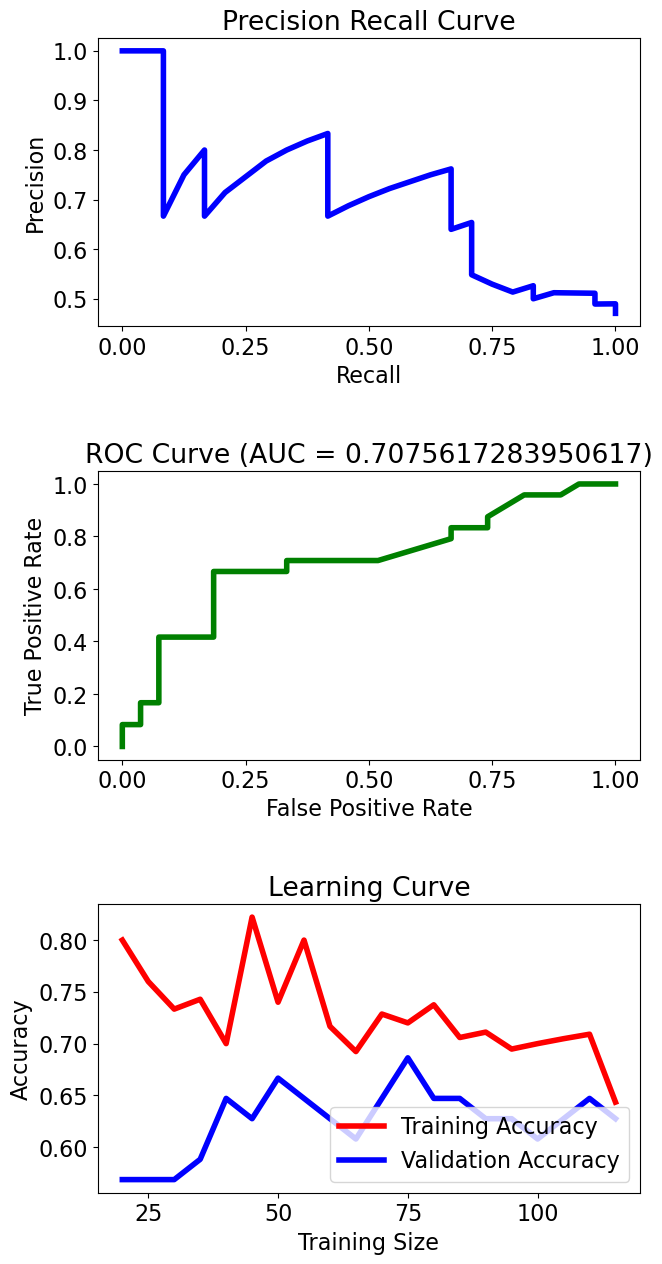

In [210]:
coef_logistic = trainLogModel(X_train, X_test, y_train, y_test)

Next we trained a logistic regression model with SGD. This producecd worse metrics than the LogisticRegression model. The PR curve shows a major bias towards precision over recall. The AUC score is very poor. The learning curve appears very stochastic and performance does not stabilize for the training or validation sets. These affects are likely due to the small dataset.

accuracy: 0.5686274509803921, precision: 0.5714285714285714, recall: 0.3333333333333333


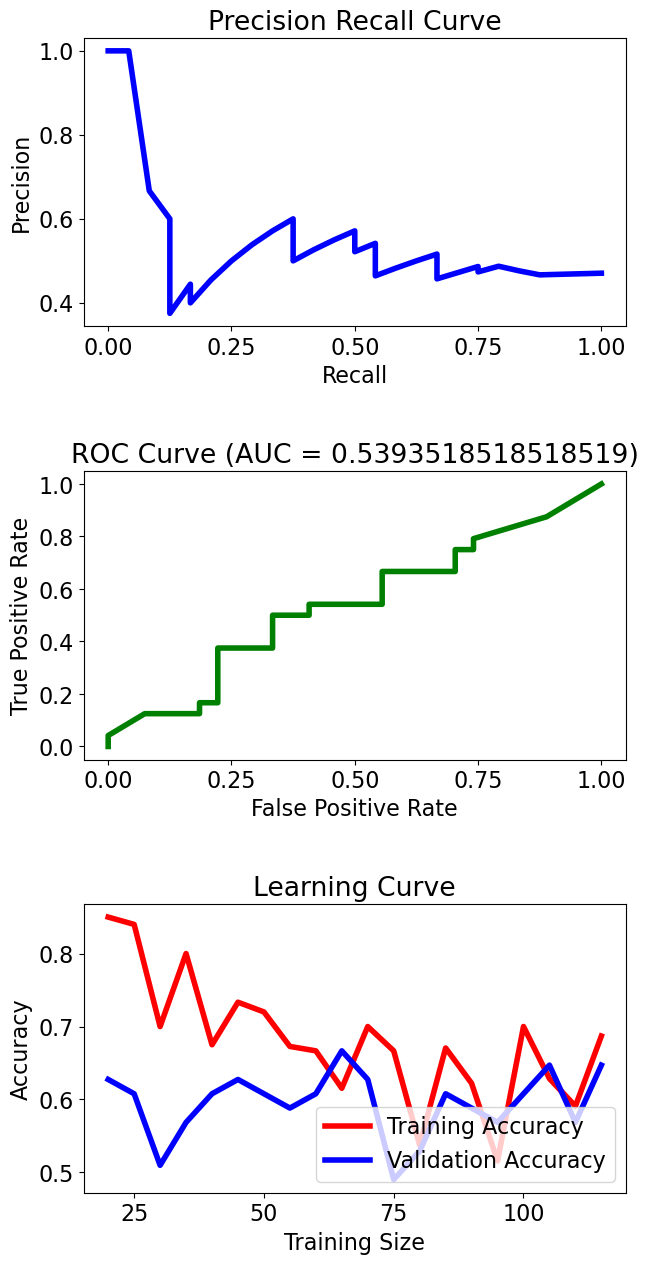

In [211]:
coef_SGD = trainSGDModel(X_train, X_test, y_train, y_test)

The SGD model with Grid Search CV performed even worse on all metrics than the SGD model without Grid Search. The plots also show the same issues as the SGD model. The small size of the training dataset likely caused the cross-validation to overfit these data, leading to worse results.

{'alpha': 0.001, 'max_iter': 1000, 'penalty': 'l1', 'tol': 0.0005}
accuracy: 0.49019607843137253, precision: 0.4166666666666667, recall: 0.20833333333333334


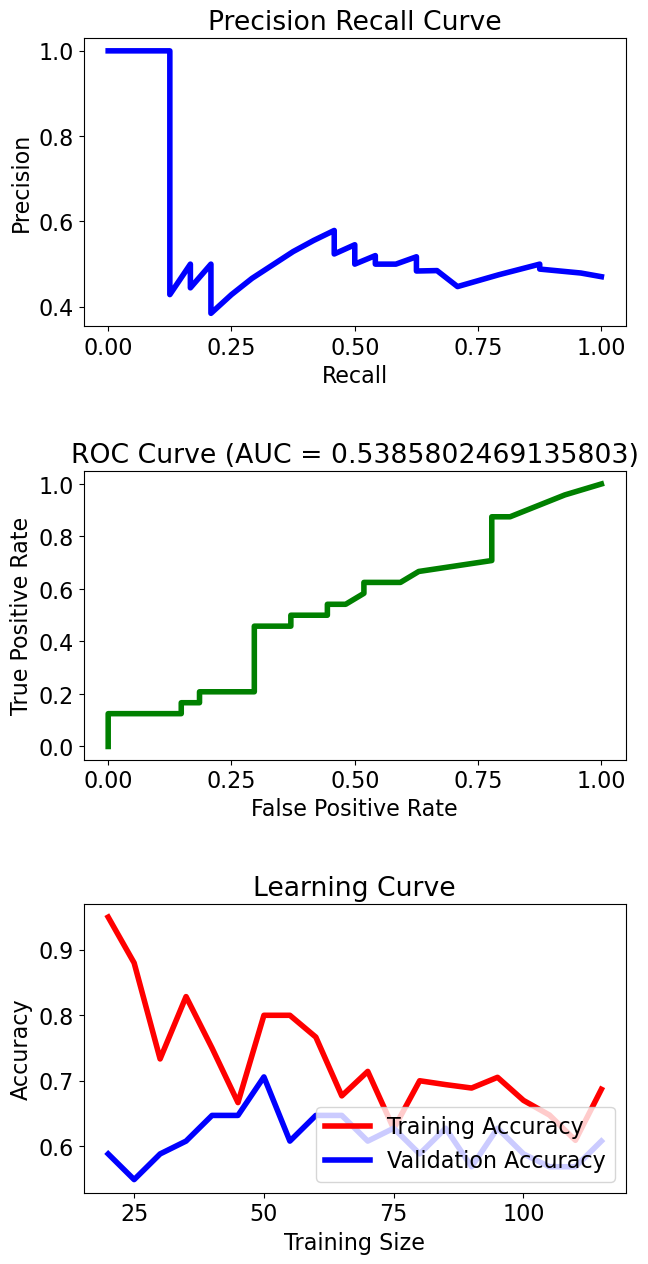

In [212]:
coef_SGDgrid = trainSGD_GridModel(X_train, X_test, y_train, y_test)

The Random Forest model produced good metrics. The precision is higher than the LogisticRegression model. This model produced a similar PR curve to the LogisticRegression model, and an ROC curve with the greatest AUC. Overall, this model was very similar to the LogisticRegression model in terms of metrics.

Best hyperparameters: {'bootstrap': False, 'max_depth': 2, 'n_estimators': 120}
accuracy: 0.6274509803921569, precision: 0.7777777777777778, recall: 0.2916666666666667


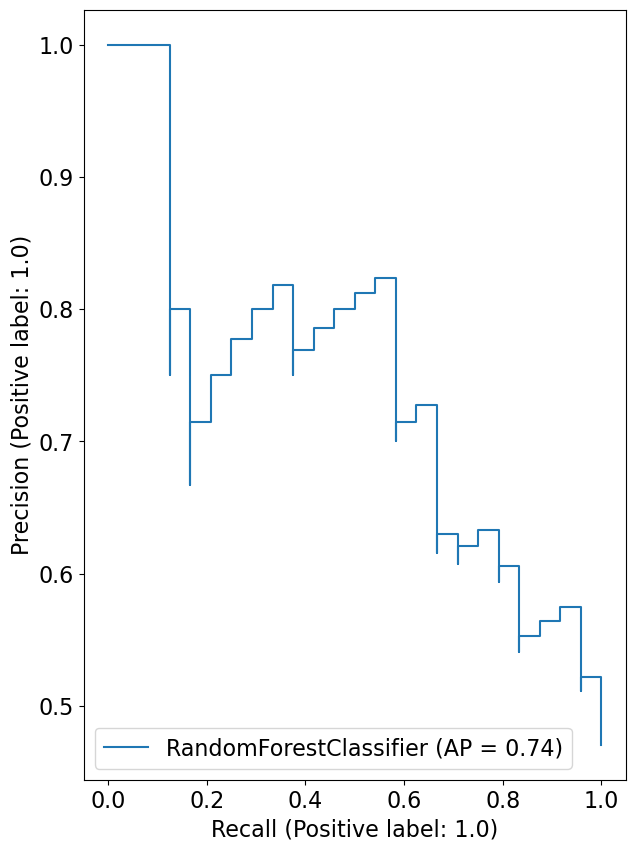

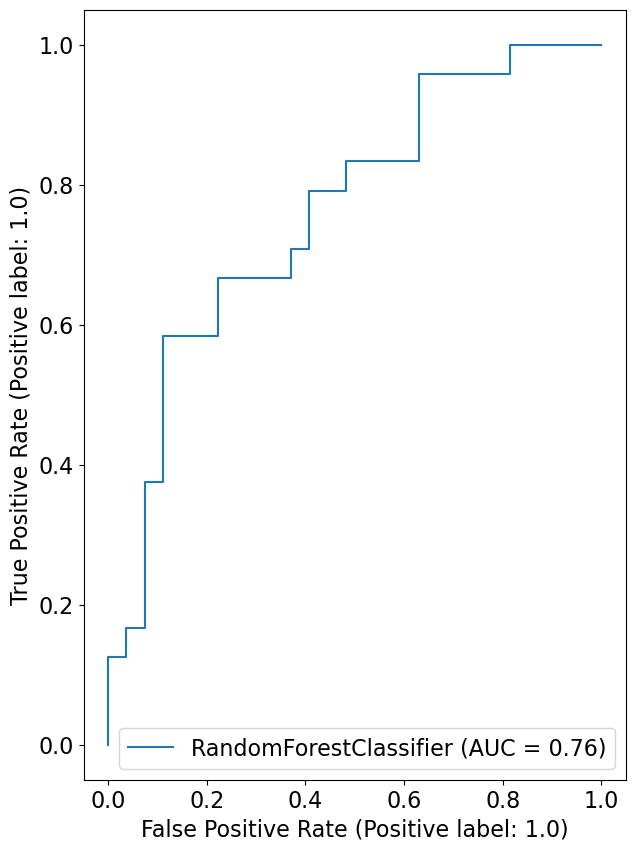

In [213]:
trainRFModel(X_train, X_test, y_train, y_test)

Despite the comparable metrics of the Random Forest model, we opted to use the LogisticRegression model for deployment. The LogisticRegression model is more straightforward in terms of interpretability than a non-linear black box model like Random Forest. Interpretability is important for the model because much of our intention is to investigate which attributes are important in determining patient survival. While the accuracy of the model is not great, it offers generalizable findings on the factors contributing to successful BMT procedures. The coefficients of the final model are used to assess Risk Factors in the deployed application.

In [214]:
coef_table = pd.DataFrame(list(X.columns), columns=["Category"])
coef_table["Coefficient"] = np.ravel(coef_logistic)
display(coef_table)

,Category,Coefficient
0,Recipientgender,0.165806
1,Stemcellsource,-0.635510
2,Donorage,0.016065
3,Gendermatch,-0.097329
4,RecipientRh,0.461719
5,ABOmatch,-0.623220
6,CMVstatus,0.146829
7,DonorCMV,-0.151626
8,RecipientCMV,-0.025980
9,Riskgroup,0.368502
